In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

print(os.getcwd())
sys.path.append(str(Path('../src').resolve()))

/media/dicarlod/SSD_2/diego/Code/INCANT/python/notebooks


In [3]:
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import scipy.interpolate as interpolate
from matplotlib.colors import LogNorm

from tqdm import tqdm

from implicits import SIREN, MFN, continuous_diff
from train import train_siren

/media/dicarlod/SSD_2/diego/Code/INCANT/python/notebooks


In [4]:
# Load Data
path_to_csv0 = Path("../../data/clippeddata/clippedMarco0.txt")
path_to_csv1 = Path("../../data/clippeddata/clippedMarco1.txt")

data_t0 = pd.read_csv(path_to_csv0).to_numpy()[:,:3]
data_t0 = np.concatenate([data_t0, np.zeros((data_t0.shape[0],1))], axis=-1)
print('Data t0:', data_t0.shape)
data_t1 = pd.read_csv(path_to_csv1).to_numpy()[:,:3]
data_t1 = np.concatenate([data_t1, np.ones((data_t1.shape[0],1))], axis=-1)
print('Data t1:', data_t1.shape)

data_t01 = np.concatenate([data_t0, data_t1], axis=0)
data_t01 = data_t01[::4,:]
col_names = ["x","y","z","t"]

print("min", np.min(data_t01, axis=0))
print("mean", np.mean(data_t01, axis=0))
print("max", np.max(data_t01, axis=0))
print("range", np.abs(np.max(data_t01, axis=0) - np.min(data_t01, axis=0)))

Data t0: (24253, 4)
Data t1: (26658, 4)
min [  6.375 216.5   248.329   0.   ]
mean [ 36.38798319 238.85586895 261.26934373   0.52357008]
max [ 64.5   261.5   275.778   1.   ]
range [58.125 45.    27.449  1.   ]


In [5]:
# Create dataloader
class MarcoDataset(torch.utils.data.Dataset):
    def __init__(self, data, col_names, device):
        self.col_names = col_names
        self.data = data
        n_obs = self.data.shape[0]
        
        self.coords = torch.Tensor(self.data[:,[0,1,3]]).to(device)
        self.target = torch.Tensor(self.data[:,2][:,None]).to(device)
        
        # normalization between [-1,1] for SIREN
        self.coords_n = self.coords - torch.mean(self.coords, dim=0, keepdim=True)
        self.coords_n = self.coords_n / torch.Tensor([[33, 27, 1]]).to(device)
        self.coords[:,:2] = self.coords_n[:,:2]
                
        print(torch.min(self.coords, dim=0)[0])
        print(torch.max(self.coords, dim=0)[0])
        
        for d in range(2):
            assert torch.max(self.coords[:,d]) <  1
            assert torch.min(self.coords[:,d]) > -1
            assert torch.any(self.coords[:,d] < 0)
        
        print(torch.min(self.coords, dim=0)[0])
        print(torch.max(self.coords, dim=0)[0])
        
        
    def __len__(self):
        return self.coords.shape[0]
    
    def __getitem__(self, idx):
        coords = self.coords[idx,:]
        target = self.target[idx,:]
        return (coords, target)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
dset_t01 = MarcoDataset(data_t01, col_names, device)
dset_t1 = MarcoDataset(data_t1, col_names, device)
dset_t0 = MarcoDataset(data_t1, col_names, device)

dset_train = dset_t0
n_obs = len(dset_train)
print(n_obs)

n_test = int((5 / 100) * n_obs)
n_val  = int((5 / 100) * n_obs)
n_train = n_obs - n_val - n_test

dset_train, dset_val, dset_test = torch.utils.data.random_split(dset_train, [n_train, n_val, n_test])
print(len(dset_train))
print(len(dset_val))
print(len(dset_test))

cuda
tensor([-0.9095, -0.8280,  0.0000], device='cuda:0')
tensor([0.8519, 0.8387, 1.0000], device='cuda:0')
tensor([-0.9095, -0.8280,  0.0000], device='cuda:0')
tensor([0.8519, 0.8387, 1.0000], device='cuda:0')
tensor([-0.8930, -0.8218,  1.0000], device='cuda:0')
tensor([0.8683, 0.8449, 1.0000], device='cuda:0')
tensor([-0.8930, -0.8218,  1.0000], device='cuda:0')
tensor([0.8683, 0.8449, 1.0000], device='cuda:0')
tensor([-0.8930, -0.8218,  1.0000], device='cuda:0')
tensor([0.8683, 0.8449, 1.0000], device='cuda:0')
tensor([-0.8930, -0.8218,  1.0000], device='cuda:0')
tensor([0.8683, 0.8449, 1.0000], device='cuda:0')
26658
23994
1332
1332


In [19]:
lr = 1e-3
epochs = 300
val_interval = 10
loss_name = 'MSE'
batch_size = 2048
hidden_dim = 256
hidden_num = 2
feature_space = 128
feature_time = 1

In [20]:
params = {'batch_size': 512,
 'feature_space': 25,
 'feature_time': 20,
 'hidden_dim': 121,
 'hidden_num': 2,
 'learning_rate': 3e-05}


In [21]:
best_model, results_dict = train_siren(
        dset_train, dset_val, device, epochs, loss_name='MAE',
        **params, 
        val_interval=val_interval, trial=None)

3e-05 512 MAE 2 121 25 20


Train Epoch [133/300] Loss: 1.66648, Metric: 9.78805:  45%|████▍     | 134/300 [00:42<00:52,  3.13it/s]

Early stopping
Best model from epoch 124


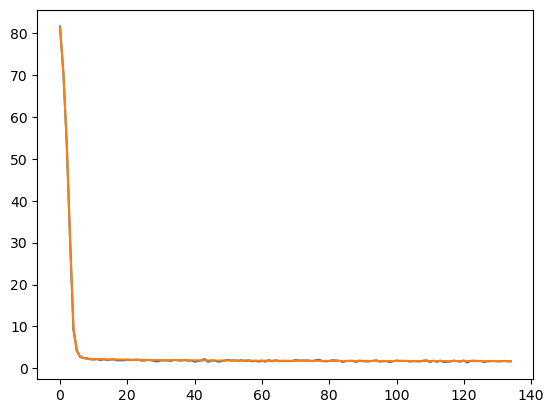

In [23]:
plt.plot(results_dict['loss_val'])
plt.plot(results_dict['loss_train'])

In [24]:
coord_test, reference = dset_t1[:]
print(coord_test)
print(coord_test.dtype)
estimaded = best_model(coord_test)

tensor([[-0.8514, -0.8218,  1.0000],
        [-0.8514, -0.7848,  1.0000],
        [-0.8514, -0.7848,  1.0000],
        ...,
        [ 0.8683,  0.8078,  1.0000],
        [ 0.8683,  0.8264,  1.0000],
        [ 0.8683,  0.8449,  1.0000]], device='cuda:0')
torch.float32


torch.Size([16384, 3])
torch.float32


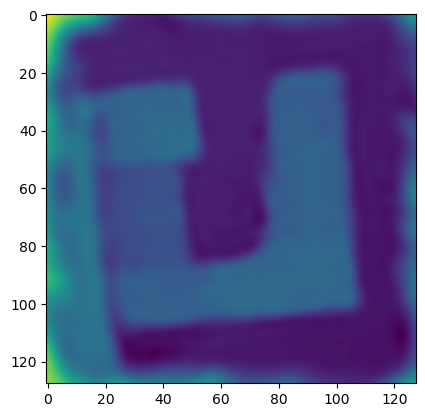

In [27]:
n_points = 128
xy = np.stack(np.meshgrid(
    np.linspace(-1, 1, n_points),
    np.linspace(-1, 1, n_points),
    np.ones_like((n_points)),
    indexing='ij'
), axis=-1)

xy = torch.from_numpy(xy).float().to(device)
original_shape = xy.shape
xy = xy.view(-1, 3)
print(xy.shape)
print(xy.dtype)

best_model.eval()
estimaded = best_model(xy)
estimaded = estimaded.reshape(n_points, n_points)

plt.imshow(estimaded.detach().cpu().numpy())
plt.show()

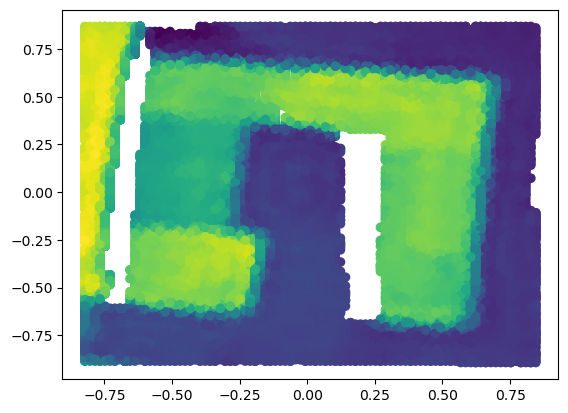

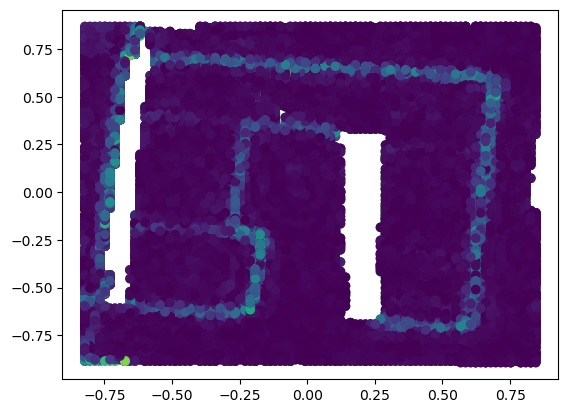

In [32]:
coords, reference = dset_train[:]

estimaded = best_model(coords)

plt.scatter(coords[:,1].detach().cpu().numpy(), 
            coords[:,0].detach().cpu().numpy(), 
            c=estimaded.detach().cpu().numpy())
plt.show()

plt.scatter(coords[:,1].detach().cpu().numpy(), 
            coords[:,0].detach().cpu().numpy(), 
            c=reference.detach().cpu().numpy())

error = torch.abs(estimaded - reference)

plt.scatter(coords[:,1].detach().cpu().numpy(), 
            coords[:,0].detach().cpu().numpy(), 
            c=error.detach().cpu().numpy())

## Optimization

In [ ]:
import optuna

In [ ]:
# 1. Define an objective function to be minimize.
def objective(trial):

    # 2. Suggest values of the hyperparameters using a trial object.
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)   
    feature_scale = trial.suggest_float('feature_scale', 2, 6000, log=True)
    feature_time = trial.suggest_float('feature_time', 2, 6000, log=True)
    batch_size = trial.suggest_int('batch_size', 4, 128, log=True)
    hidden_num = trial.suggest_int('hidden_num', 1, 5)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 1024, log=True)

    epochs = 1000

    dset_t01 = MarcoDataset(data_t01, col_names, device)
    n_obs = len(dset_t01)
    print(n_obs)

    n_test = int((10 / 100) * n_obs)
    n_val  = int((10 / 100) * n_obs)
    n_train = n_obs - n_val - n_test

    dset_train, dset_val, dset_test = torch.utils.data.random_split(dset_t01, [n_train, n_val, n_test])    
    best_model, results_dict = train_siren(
        dset_train, dset_val, device, epochs,
        learning_rate, batch_size, 'MSE', hidden_num, hidden_dim, feature_space, feature_time, 
        val_interval=10, trial=None)
    error = results_dict['metrics'][-1]['mse']

    return error

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(
        storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
        direction='minimize',
        sampler=optuna.samplers.TPESampler(), # Bayesian search
        pruner=optuna.pruners.MedianPruner(), # Pruning        
    )
study.optimize(objective, n_trials=100)

In [ ]:
study.best_params